In [ ]:
from dotenv import load_dotenv
import os
load_dotenv(dotenv_path = "D:\Learning\.env")

apikey = os.getenv("GOOGLE_API_KEY")
if apikey:
    print("Google API key found and loaded successfully!")
else:
    print("Google API key not found.")

Google API key found and loaded successfully!


In [2]:
from typing import Any, Dict

from google.adk.agents import Agent, LlmAgent
from google.adk.apps.app import App, EventsCompactionConfig
from google.adk.models.google_llm import Gemini
from google.adk.sessions import DatabaseSessionService
from google.adk.sessions import InMemorySessionService
from google.adk.runners import Runner
from google.adk.tools.tool_context import ToolContext
from google.genai import types

print("✅ ADK components imported successfully.")

✅ ADK components imported successfully.


In [3]:
# Define helper functions that will be reused throughout the notebook
async def run_session(
    runner_instance: Runner,
    user_queries: list[str] | str = None,
    session_name: str = "default",
):
    print(f"\n ### Session: {session_name}")

    # Get app name from the Runner
    app_name = runner_instance.app_name

    # Attempt to create a new session or retrieve an existing one
    try:
        session = await session_service.create_session(
            app_name=app_name, user_id=USER_ID, session_id=session_name
        )
    except:
        session = await session_service.get_session(
            app_name=app_name, user_id=USER_ID, session_id=session_name
        )

    # Process queries if provided
    if user_queries:
        # Convert single query to list for uniform processing
        if type(user_queries) == str:
            user_queries = [user_queries]

        # Process each query in the list sequentially
        for query in user_queries:
            print(f"\nUser > {query}")

            # Convert the query string to the ADK Content format
            query = types.Content(role="user", parts=[types.Part(text=query)])

            # Stream the agent's response asynchronously
            async for event in runner_instance.run_async(
                user_id=USER_ID, session_id=session.id, new_message=query
            ):
                # Check if the event contains valid content
                if event.content and event.content.parts:
                    # Filter out empty or "None" responses before printing
                    if (
                        event.content.parts[0].text != "None"
                        and event.content.parts[0].text
                    ):
                        print(f"{MODEL_NAME} > ", event.content.parts[0].text)
    else:
        print("No queries!")


print("✅ Helper functions defined.")

✅ Helper functions defined.


In [4]:
retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)

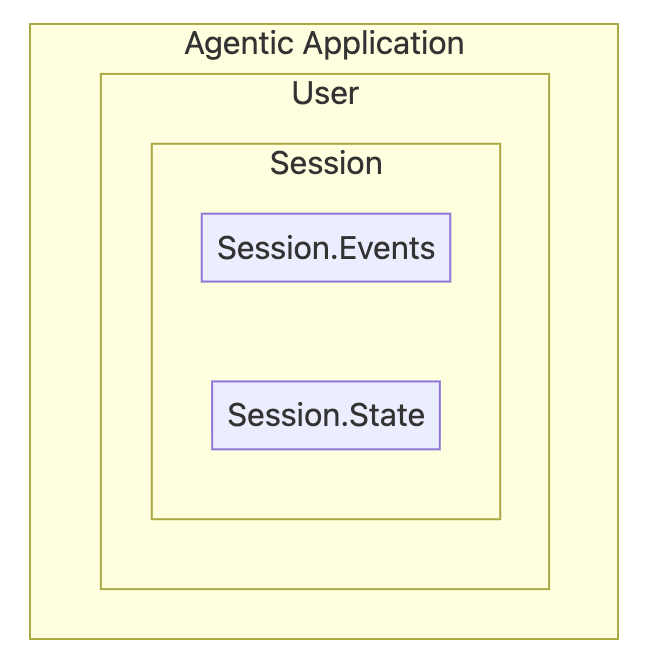

In [6]:
APP_NAME = "default"  # Application
USER_ID = "default"  # User
SESSION = "default"  # Session

MODEL_NAME = "gemini-2.5-flash-lite"


# Step 1: Create the LLM Agent
root_agent = Agent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="text_chat_bot",
    description="A text chatbot",  # Description of the agent's purpose
)

# Step 2: Set up Session Management
# InMemorySessionService stores conversations in RAM (temporary)
session_service = InMemorySessionService()

# Step 3: Create the Runner
runner = Runner(agent=root_agent, app_name=APP_NAME, session_service=session_service)

print("✅ Stateful agent initialized!")
print(f"   - Application: {APP_NAME}")
print(f"   - User: {USER_ID}")
print(f"   - Using: {session_service.__class__.__name__}")

✅ Stateful agent initialized!
   - Application: default
   - User: default
   - Using: InMemorySessionService


In [7]:
# Run a conversation with two queries in the same session
# Notice: Both queries are part of the SAME session, so context is maintained
await run_session(
    runner,
    [
        "Hi, I am Sam! What is the capital of United States?",
        "Hello! What is my name?",  # This time, the agent should remember!
    ],
    "stateful-agentic-session",
)


 ### Session: stateful-agentic-session

User > Hi, I am Sam! What is the capital of United States?
gemini-2.5-flash-lite >  Hi Sam! The capital of the United States is Washington, D.C.

User > Hello! What is my name?
gemini-2.5-flash-lite >  Your name is Sam.


In [8]:
# Run this cell after restarting the kernel. All this history will be gone...
await run_session(
    runner,
    ["What did I ask you about earlier?", "And remind me, what's my name?"],
    "stateful-agentic-session",
)  # Note, we are using same session name


 ### Session: stateful-agentic-session

User > What did I ask you about earlier?
gemini-2.5-flash-lite >  You asked me about the capital of the United States.

User > And remind me, what's my name?
gemini-2.5-flash-lite >  Your name is Sam.


In [11]:
# Step 1: Create the same agent (notice we use LlmAgent this time)
chatbot_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="text_chat_bot",
    description="A text chatbot with persistent memory",
)

# Step 2: Switch to DatabaseSessionService
# SQLite database will be created automatically
db_url = "sqlite:///my_agent_data.db"  # Local SQLite file
session_service = DatabaseSessionService(db_url=db_url)

# Step 3: Create a new runner with persistent storage
runner = Runner(agent=chatbot_agent, app_name=APP_NAME, session_service=session_service)

print("✅ Upgraded to persistent sessions!")
print(f"   - Database: my_agent_data.db")
print(f"   - Sessions will survive restarts!")

✅ Upgraded to persistent sessions!
   - Database: my_agent_data.db
   - Sessions will survive restarts!


In [10]:
await run_session(
    runner,
    ["Hi, I am Sam! What is the capital of the United States?", "Hello! What is my name?"],
    "test-db-session-01",
)


 ### Session: test-db-session-01

User > Hi, I am Sam! What is the capital of the United States?
gemini-2.5-flash-lite >  Hi Sam! The capital of the United States is Washington, D.C.

User > Hello! What is my name?
gemini-2.5-flash-lite >  Your name is Sam.


In [7]:
await run_session(
    runner,
    ["What is the capital of India?", "Hello! What is my name?"],
    "test-db-session-01",
)


 ### Session: test-db-session-01

User > What is the capital of India?
gemini-2.5-flash-lite >  The capital of India is New Delhi.

User > Hello! What is my name?
gemini-2.5-flash-lite >  I am sorry, but I do not have access to your personal information, including your name. I am a text-based chatbot and do not have the ability to identify users.


In [8]:
await run_session(
    runner, ["Hello! What is my name?"], "test-db-session-02"
)  # Note, we are using new session name


 ### Session: test-db-session-02

User > Hello! What is my name?
gemini-2.5-flash-lite >  I do not have access to your personal information, so I do not know your name.


In [9]:
import sqlite3

def check_data_in_db():
    with sqlite3.connect("my_agent_data.db") as connection:
        cursor = connection.cursor()
        result = cursor.execute(
            "select app_name, session_id, author, content from events"
        )
        print([_[0] for _ in result.description])
        for each in result.fetchall():
            print(each)


check_data_in_db()

['app_name', 'session_id', 'author', 'content']
('default', 'test-db-session-01', 'user', '{"parts": [{"text": "Hi, I am Sam! What is the capital of the United States?"}], "role": "user"}')
('default', 'test-db-session-01', 'text_chat_bot', '{"parts": [{"text": "Hi Sam! The capital of the United States is Washington, D.C."}], "role": "model"}')
('default', 'test-db-session-01', 'user', '{"parts": [{"text": "Hello! What is my name?"}], "role": "user"}')
('default', 'test-db-session-01', 'text_chat_bot', '{"parts": [{"text": "Your name is Sam."}], "role": "model"}')


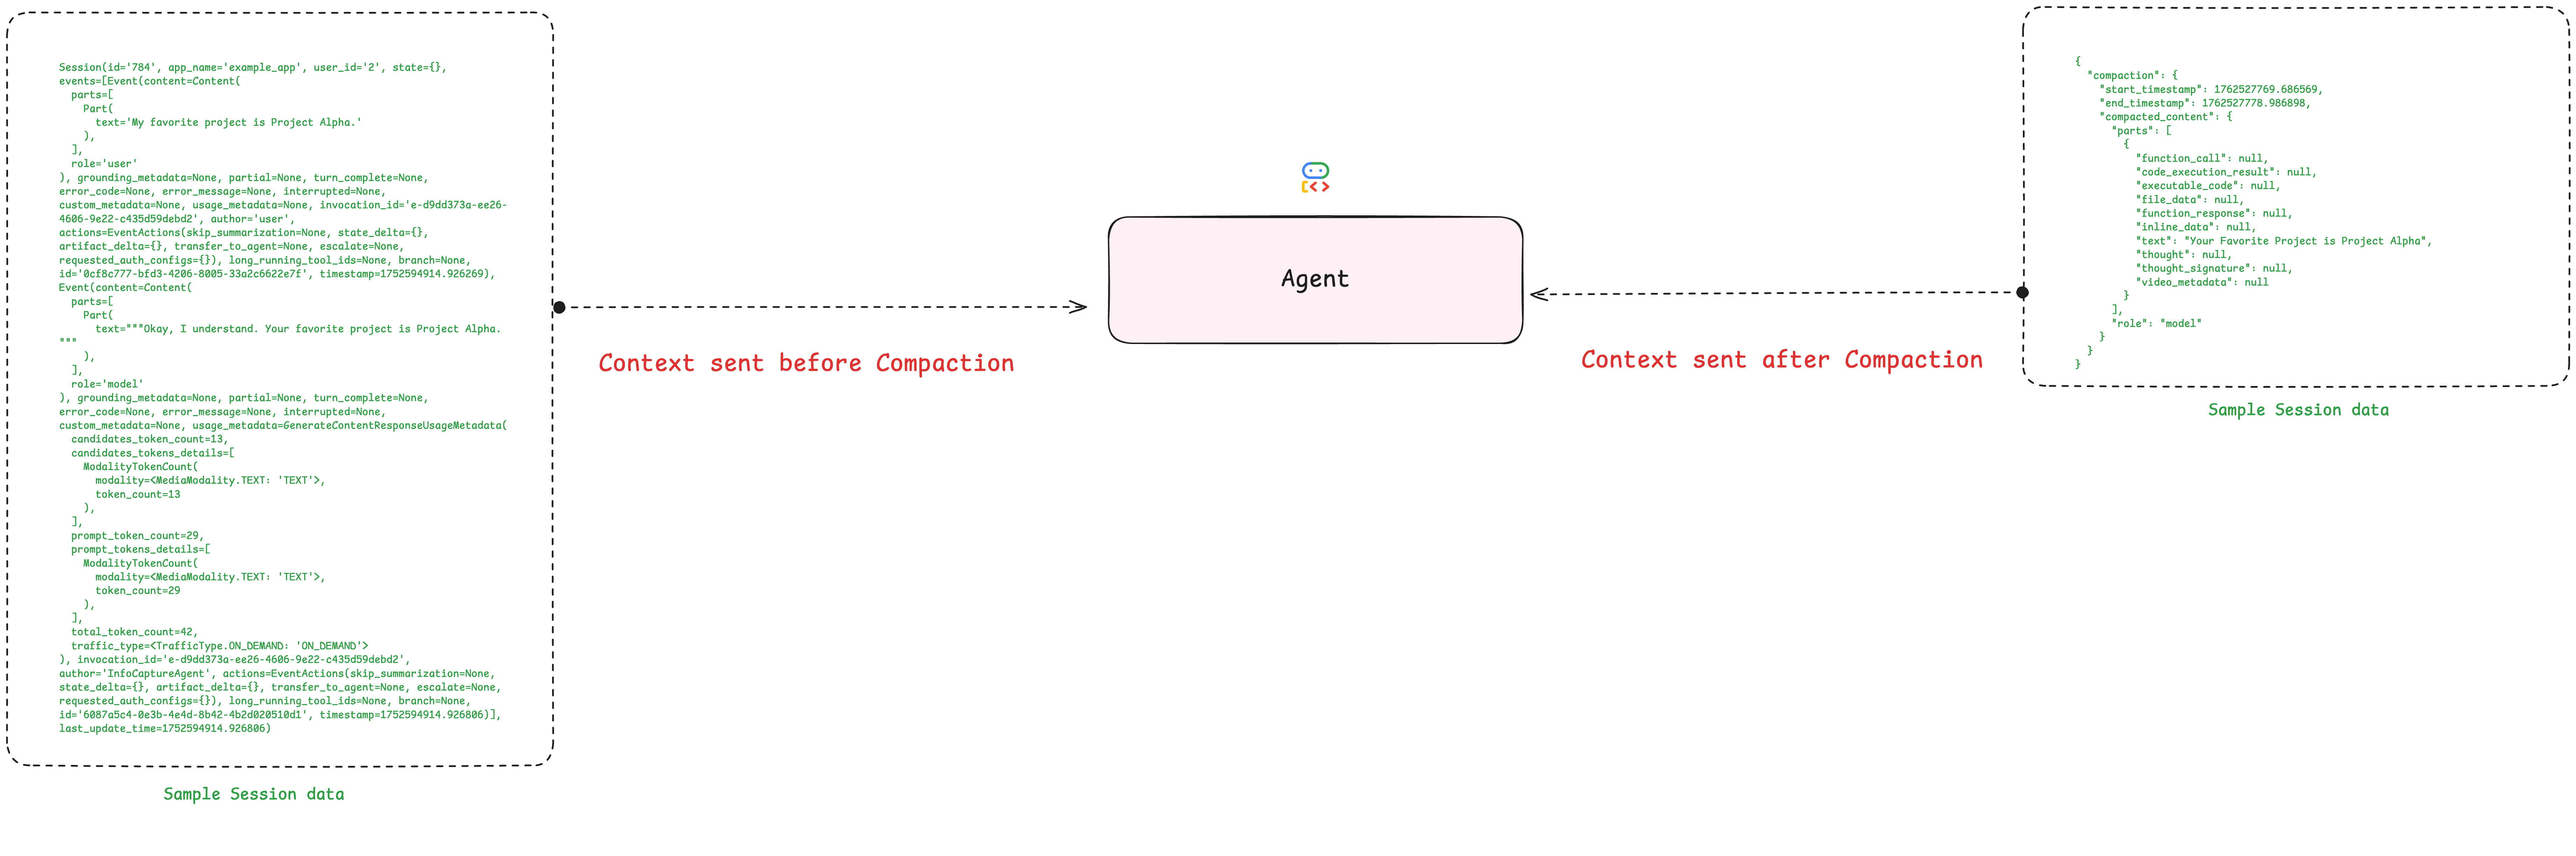

In [12]:
# Re-define our app with Events Compaction enabled
research_app_compacting = App(
    name="research_app_compacting",
    root_agent=chatbot_agent,
    # This is the new part!
    events_compaction_config=EventsCompactionConfig(
        compaction_interval=3,  # Trigger compaction every 3 invocations
        overlap_size=1,  # Keep 1 previous turn for context
    ),
)

db_url = "sqlite:///my_agent_data.db"  # Local SQLite file
session_service = DatabaseSessionService(db_url=db_url)

# Create a new runner for our upgraded app
research_runner_compacting = Runner(
    app=research_app_compacting, session_service=session_service
)


print("✅ Research App upgraded with Events Compaction!")

✅ Research App upgraded with Events Compaction!


C:\Users\sande\AppData\Local\Temp\ipykernel_25936\3773147741.py:6: UserWarning: [EXPERIMENTAL] EventsCompactionConfig: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  events_compaction_config=EventsCompactionConfig(


In [14]:
# Turn 1
await run_session(
    research_runner_compacting,
    "What is the latest news about AI in healthcare?",
    "compaction_demo",
)

# Turn 2
await run_session(
    research_runner_compacting,
    "Are there any new developments in drug discovery?",
    "compaction_demo",
)

# Turn 3 - Compaction should trigger after this turn!
await run_session(
    research_runner_compacting,
    "Tell me more about the second development you found.",
    "compaction_demo",
)

# Turn 4
await run_session(
    research_runner_compacting,
    "Who are the main companies involved in that?",
    "compaction_demo",
)


 ### Session: compaction_demo

User > What is the latest news about AI in healthcare?
gemini-2.5-flash-lite >  The field of AI in healthcare is evolving rapidly, with new developments emerging constantly. Here's a snapshot of some of the latest and most significant trends and news:

**1. Advancements in Diagnostic Imaging and Analysis:**

*   **Improved Accuracy and Speed:** AI algorithms are becoming increasingly sophisticated at analyzing medical images like X-rays, CT scans, and MRIs. They can detect subtle anomalies that might be missed by the human eye, leading to earlier and more accurate diagnoses for conditions like cancer, diabetic retinopathy, and cardiovascular diseases.
*   **Radiology Workflow Optimization:** AI tools are helping radiologists prioritize urgent cases, reduce their workload by automating routine tasks, and improve the overall efficiency of diagnostic departments.
*   **Pathology Integration:** AI is also making inroads in digital pathology, assisting pathol

In [15]:
# Get the final session state
final_session = await session_service.get_session(
    app_name=research_runner_compacting.app_name,
    user_id=USER_ID,
    session_id="compaction_demo",
)

print("--- Searching for Compaction Summary Event ---")
found_summary = False
for event in final_session.events:
    # Compaction events have a 'compaction' attribute
    if event.actions and event.actions.compaction:
        print("\n✅ SUCCESS! Found the Compaction Event:")
        print(f"  Author: {event.author}")
        print(f"\n Compacted information: {event}")
        found_summary = True
        break

if not found_summary:
    print(
        "\n❌ No compaction event found. Try increasing the number of turns in the demo."
    )

--- Searching for Compaction Summary Event ---

✅ SUCCESS! Found the Compaction Event:
  Author: user

 Compacted information: model_version=None content=None grounding_metadata=None partial=None turn_complete=None finish_reason=None error_code=None error_message=None interrupted=None custom_metadata=None usage_metadata=None live_session_resumption_update=None input_transcription=None output_transcription=None avg_logprobs=None logprobs_result=None cache_metadata=None citation_metadata=None invocation_id='930c6c18-f036-4ce0-8086-d30aff69332b' author='user' actions=EventActions(skip_summarization=None, state_delta={}, artifact_delta={}, transfer_to_agent=None, escalate=None, requested_auth_configs={}, requested_tool_confirmations={}, compaction={'start_timestamp': 1762972411.196107, 'end_timestamp': 1762972422.254397, 'compacted_content': {'parts': [{'function_call': None, 'code_execution_result': None, 'executable_code': None, 'file_data': None, 'function_response': None, 'inline_data'

In [17]:
# Define scope levels for state keys (following best practices)
USER_NAME_SCOPE_LEVELS = ("temp", "user", "app")


# This demonstrates how tools can write to session state using tool_context.
# The 'user:' prefix indicates this is user-specific data.
def save_userinfo(
    tool_context: ToolContext, user_name: str, country: str
) -> Dict[str, Any]:
    """
    Tool to record and save user name and country in session state.

    Args:
        user_name: The username to store in session state
        country: The name of the user's country
    """
    # Write to session state using the 'user:' prefix for user data
    tool_context.state["user:name"] = user_name
    tool_context.state["user:country"] = country

    return {"status": "success"}


# This demonstrates how tools can read from session state.
def retrieve_userinfo(tool_context: ToolContext) -> Dict[str, Any]:
    """
    Tool to retrieve user name and country from session state.
    """
    # Read from session state
    user_name = tool_context.state.get("user:name", "Username not found")
    country = tool_context.state.get("user:country", "Country not found")

    return {"status": "success", "user_name": user_name, "country": country}


print("✅ Tools created.")

✅ Tools created.


In [18]:
# Configuration
APP_NAME = "default"
USER_ID = "default"
MODEL_NAME = "gemini-2.5-flash-lite"

# Create an agent with session state tools
root_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="text_chat_bot",
    description="""A text chatbot.
    Tools for managing user context:
    * To record username and country when provided use `save_userinfo` tool. 
    * To fetch username and country when required use `retrieve_userinfo` tool.
    """,
    tools=[save_userinfo, retrieve_userinfo],  # Provide the tools to the agent
)

# Set up session service and runner
session_service = InMemorySessionService()
runner = Runner(agent=root_agent, session_service=session_service, app_name="default")

print("✅ Agent with session state tools initialized!")

✅ Agent with session state tools initialized!


In [19]:
# Test conversation demonstrating session state
await run_session(
    runner,
    [
        "Hi there, how are you doing today? What is my name?",  # Agent shouldn't know the name yet
        "My name is Sam. I'm from Poland.",  # Provide name - agent should save it
        "What is my name? Which country am I from?",  # Agent should recall from session state
    ],
    "state-demo-session",
)


 ### Session: state-demo-session

User > Hi there, how are you doing today? What is my name?
gemini-2.5-flash-lite >  Hello! I'm doing great, thank you for asking. I can't recall your name just yet, but I'd be happy to remember it if you tell me!


User > My name is Sam. I'm from Poland.


gemini-2.5-flash-lite >  It is a pleasure to meet you, Sam! I've saved your information. How can I help you further?


User > What is my name? Which country am I from?


gemini-2.5-flash-lite >  Your name is Sam and you are from Poland.


In [20]:
# Retrieve the session and inspect its state
session = await session_service.get_session(
    app_name=APP_NAME, user_id=USER_ID, session_id="state-demo-session"
)

print("Session State Contents:")
print(session.state)
print("\n🔍 Notice the 'user:name' and 'user:country' keys storing our data!")

Session State Contents:
{'user:name': 'Sam', 'user:country': 'Poland'}

🔍 Notice the 'user:name' and 'user:country' keys storing our data!


In [21]:
# Start a completely new session - the agent won't know our name
await run_session(
    runner,
    ["Hi there, how are you doing today? What is my name?"],
    "new-isolated-session",
)

# Expected: The agent won't know the name because this is a different session


 ### Session: new-isolated-session

User > Hi there, how are you doing today? What is my name?
gemini-2.5-flash-lite >  Hello! I'm doing well, thank you for asking. I'm not sure what your name is, though. Would you like to tell me?


In [22]:
# Check the state of the new session
session = await session_service.get_session(
    app_name=APP_NAME, user_id=USER_ID, session_id="new-isolated-session"
)

print("New Session State:")
print(session.state)

# Note: Depending on implementation, you might see shared state here.
# This is where the distinction between session-specific and user-specific state becomes important.

New Session State:
{'user:name': 'Sam', 'user:country': 'Poland'}


In [1]:
# Clean up any existing database to start fresh (if Notebook is restarted)
import os

if os.path.exists("my_agent_data.db"):
    os.remove("my_agent_data.db")
print("✅ Cleaned up old database files")

✅ Cleaned up old database files
